# Video Generation for Aerodactylus - Sub Rosa Sunburst

This notebook is used to generate video content for Sub Rosa Sunburst using the tools provided in the `aeraudioviz` package.

In [1]:
from aeraudioviz.audio import Audio, AudioFeatures
from aeraudioviz.audio.feature_utils import add_random_noise_column, add_sine_wave_column, fade_in_between_times, fade_out_between_times, set_to_zero_between_times
from aeraudioviz.image import BaseImage, ImageModifiers
from aeraudioviz.video import VideoGenerator, ModifierMapping

## Load the Audio File

Here we create an instance of the `Audio` class based on the input audio file.

In [2]:
audio = Audio('Aerodactylus - Jetsam Dreams - 08 Sub Rosa Sunburst.wav')

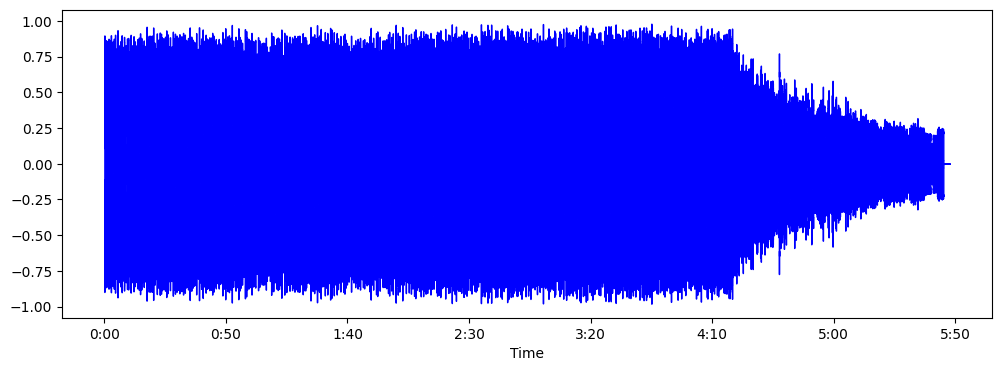

In [3]:
audio.plot_waveform()

## Extract Features from the Audio

Now we creat a `pandas.DataFrame` containing a time series of data features that will be used to manipulate the image in each frame of the video.

In [4]:
features = AudioFeatures(audio)

In [5]:
df = features.get_feature_time_series()

## Add Custom Features

Now we add some more custom features to the `DataFrame` that are not directly based on the audio data.

In [6]:
df = add_random_noise_column(df, column_name='Noise')

In [7]:
bpm = 89.
df = add_sine_wave_column(df, frequency_Hz=0.1, column_name='LFO Slow')
df = add_sine_wave_column(df, frequency_Hz=bpm / 60., column_name='LFO Medium')
df = add_sine_wave_column(df, frequency_Hz=10., column_name='LFO Fast')
df = add_sine_wave_column(df, frequency_Hz=bpm / 60. / 4, column_name='LFO Sync')

In [8]:
df['Filtered Medium LFO'] = df['LFO Medium']
df.loc[df['Beats With Decay'].rolling(30).max().fillna(0.) < 0.1, 'Filtered Medium LFO'] = 0.
df['Filtered Medium LFO'] *= df['Noise']

In [9]:
df['LFO Slow + Noise'] = df['LFO Slow'] + df['Noise'] * .3

In [10]:
df['Onset HLines'] = df['Onset'].copy()

In [11]:
df['RMS Copy'] = df['RMS'].copy()

In [12]:
filt = df['Beats With Decay'] > df['Onset']
df['Onset Corrected'] = df['Onset'].copy()
df.loc[filt, 'Onset Corrected'] = df.loc[filt, 'Beats With Decay']

## Plot the Time Series Features

These resulting features will be used to drive the dynamic effects in the video we generate later.

In [13]:
df = set_to_zero_between_times(df, 'Filtered Medium LFO', 0., 129.4167)
df = set_to_zero_between_times(df, 'Filtered Medium LFO', 258.875, audio.duration)

df = set_to_zero_between_times(df, 'LFO Sync', 0., 172.75)
df = set_to_zero_between_times(df, 'LFO Sync', 258.875, audio.duration)

df = set_to_zero_between_times(df, 'Onset HLines', 0., 129.4167)
df = fade_in_between_times(df, 'Onset HLines', 129.4167, 259., factor=0.85)
df = fade_out_between_times(df, 'Onset HLines', 258.875, audio.duration)
df = fade_out_between_times(df, 'Onset HLines', 258.875, audio.duration)
df = fade_out_between_times(df, 'Onset HLines', 258.875, audio.duration)  # apply 3 times for cubic fade

df = set_to_zero_between_times(df, 'RMS', 0., 129.4167)
df = fade_in_between_times(df, 'RMS', 129.4167, 259., factor=0.85)
df = fade_out_between_times(df, 'RMS', 258.875, audio.duration)
df = fade_out_between_times(df, 'RMS', 258.875, audio.duration)
df = fade_out_between_times(df, 'RMS', 258.875, audio.duration)  # apply 3 times for cubic fade

df = fade_out_between_times(df, 'LFO Slow + Noise', 258.875, audio.duration)
df = fade_out_between_times(df, 'LFO Slow + Noise', 258.875, audio.duration)

df = set_to_zero_between_times(df, 'Spectral Centroid', 345., audio.duration)
df = set_to_zero_between_times(df, 'Spectral Centroid Rolling Mean', 345., audio.duration)

## Plot the Time Series Features

These resulting features will be used to drive the dynamic effects in the video we generate later.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

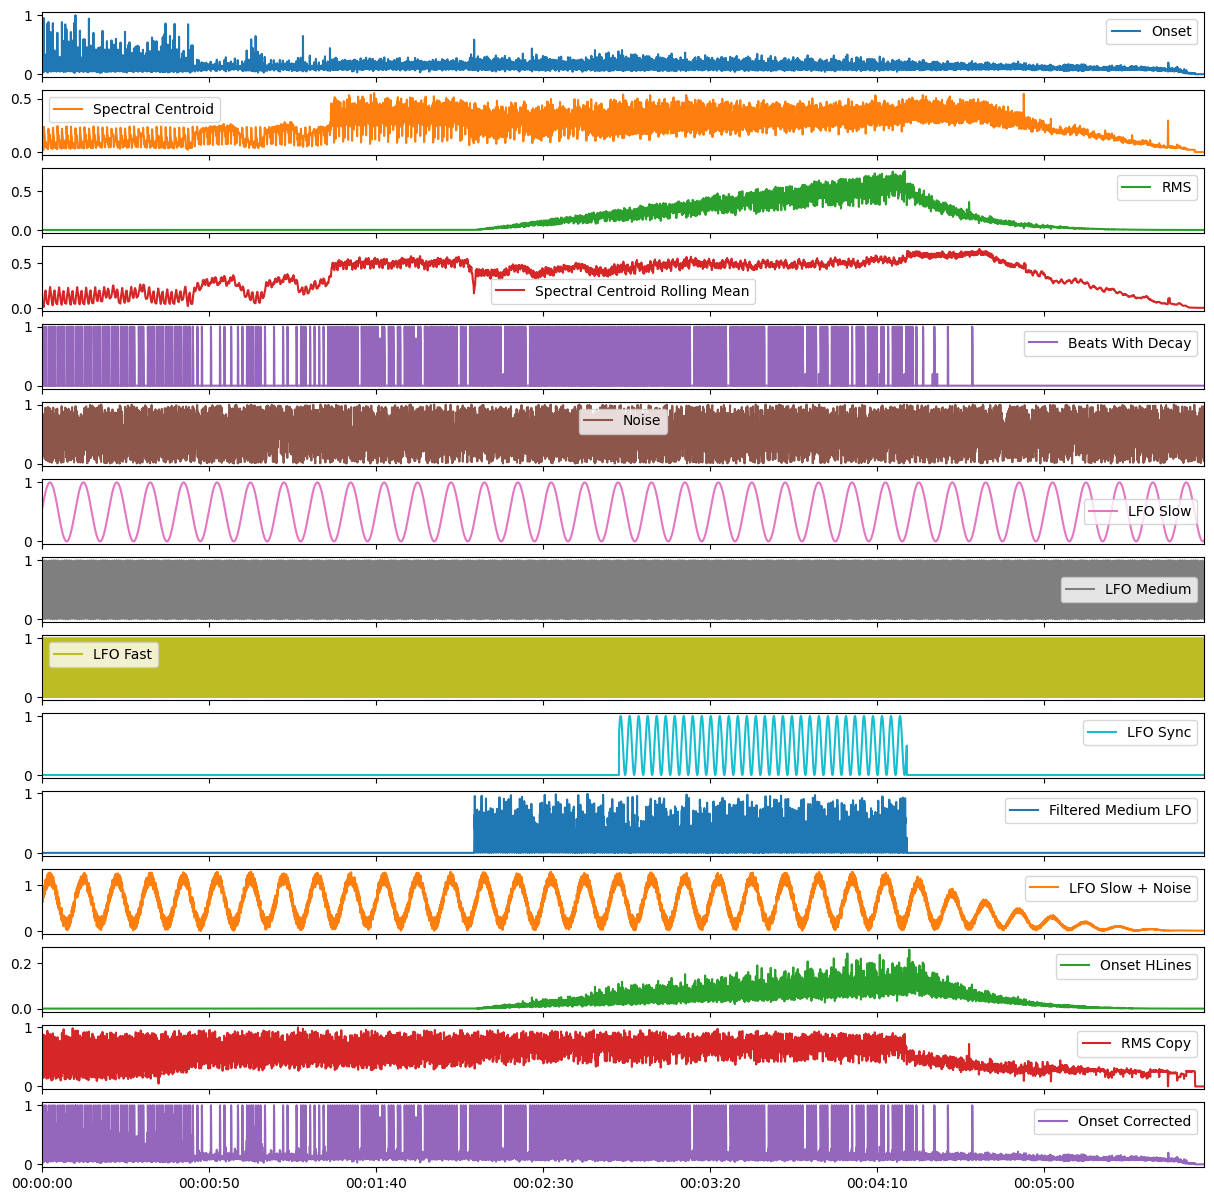

In [14]:
df.plot(subplots=True, figsize=(15, len(df.columns)))

## Load Base Image

The video will be generated by manipulating a base image based on the time series features generated previously. Here we load the base image.

In [15]:
image = BaseImage('cover.jpg')

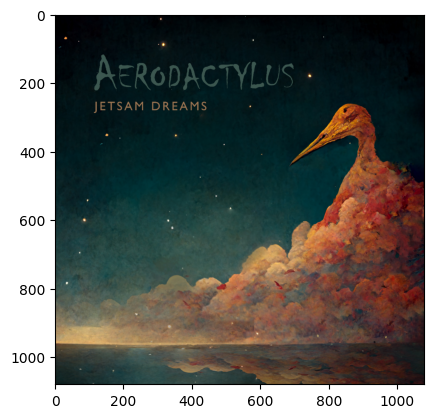

In [16]:
image.show()

## Define Mappings for Image Modification

We now define how the data columns in the time series features `DataFrame` are used to modify the image for each frame of the video.

Each `ModifierMapping` defines the following:
* `modifier_function`: the video effect function
* `modifier_column`: the data column from the time series `DataFrame` which is used to control the parameters of the `modifier_function` in each frame
* parameters: passed as `**kwargs` to the `ModifierMapping` class, key word argument name is the name of a parameter of the `modifier_function` and the value is a `tuple` defining the range of the values the function will take on at the min and max values of the data in the `modifier_column`.

In [17]:
modifier_mappings = (
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_saturation_multiplication,
        modifier_column = 'Spectral Centroid Rolling Mean',
        saturation_factor = (.5, 1.75)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_red_vlines,
        modifier_column = 'RMS',
        no_lines = (0, 8),
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_random_coloured_hlines,
        modifier_column = 'Onset HLines',
        no_lines = (0, 10),
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_hue_multiplication,
        modifier_column = 'Filtered Medium LFO',
        hue_factor = (1., 4.)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_salt_and_pepper_noise,
        modifier_column = 'Spectral Centroid',
        noise_ratio = (0., .0013)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_rgb_multiplication,
        modifier_column = 'LFO Slow',
        blue_factor = (1., 0.5)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_red_scaling,
        modifier_column = 'LFO Slow + Noise',
        scale_factor = (.0, .15)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_rgb_multiplication,
        modifier_column = 'LFO Slow + Noise',
        green_factor = (1., 1.25)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_gaussian_noise,
        modifier_column = 'Spectral Centroid',
        standard_deviation = (0., .5)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_ghost_images,
        modifier_column = 'RMS Copy',
        number_of_ghost_images = (0, 10),
        alpha = (.1, .2)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_saturation_multiplication,
        modifier_column = 'Beats With Decay',
        saturation_factor = (1., 1.75)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_gaussian_blur,
        modifier_column = 'Beats With Decay',
        kernel_size = (0, 15)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_hue_multiplication_to_area,
        modifier_column = 'LFO Sync',
        area_width = (0., 1.),
        area_height = (0., 1.),
        mod_factor = (1., 3.)
    )
)

## Generate Video

Now that we have defined the audio, base image, feature time series data, and modifier mappings we can proceed to generate the video.

In [18]:
video = VideoGenerator(
    base_image=image, 
    feature_time_series=df, 
    modifier_mappings=modifier_mappings,
    audio=audio
)

In [19]:
output_file_name = audio.audio_path.split('.')[0] + '.mp4'
video.generate(output_file_name)

Generating video frames...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8349/8349 [35:46<00:00,  3.89it/s]


Frames generated.
Setting audio...
Audio set.
Writing video...
Moviepy - Building video Aerodactylus - Jetsam Dreams - 08 Sub Rosa Sunburst.mp4.
MoviePy - Writing audio in Aerodactylus - Jetsam Dreams - 08 Sub Rosa SunburstTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video Aerodactylus - Jetsam Dreams - 08 Sub Rosa Sunburst.mp4



Moviepy - Done !
Moviepy - video ready Aerodactylus - Jetsam Dreams - 08 Sub Rosa Sunburst.mp4
Video written successfully to Aerodactylus - Jetsam Dreams - 08 Sub Rosa Sunburst.mp4.
